# ▶️ Initial Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
ROOT_DIR = "data/eq/"

In [2]:
import os, sys
sys.path.append("src/")
sys.path.append("../src/")

In [3]:
# Import modules for LLM finetuning and evaluation
import finetune as ft
import evaluate as ev

In [29]:
import model_prompts as prompts
from evaluate import EvaluationConfig

def evaluate_model(configurations, model, tokenizer, label_names, eval_dataset):
    results = []
    for config in configurations:
        result = ev.evaluate(
            model=model, tokenizer=tokenizer, label_names=label_names,
            eval_dataset=dataset['test'], eval_config=config
        )
        results.append(result)
    return results

def save_results(results):
    for result in results:
        result.save(os.path.join(ROOT_DIR, "results")) # Saves to "data/eq/results/<EvaluationConfig.name>"

# ▶️ Load EQ dataset

In [5]:
import pandas as pd

data = pd.read_csv(
    os.path.join(ROOT_DIR, "datasets/preprocessed.csv"),
    low_memory=False)

In [6]:
input_features = [
"OUTAGE_ID",
"WEATHER_CONDITION",
"OUTAGE_CAUSE",
"FAULT_LONG_DESCRIPTION",
"SHORT_DESC_2",
"WORK_ORDER_COMPONENT_CODE_DESCRIPTION",
"OUTAGE_CAUSE_GROUP",
"OUTAGE_STANDARD_REASON_DESCRIPTION",
"REASON_FOR_INTERRUPTION",
"PROVIDER"
]

output_labels = [
    "MSSS_OBJECT_DESCRIPTION",
    "MSSS_DAMAGE_DESCRIPTION",
    "MSSS_CAUSE_DESCRIPTION"
]

In [7]:
# Shuffle the data in a deterministic way
data = data.sample(frac=1, random_state=42)

In [8]:
# Supervised dataset
data_train = data.dropna(subset=output_labels, how='any')

# Unsupervised dataset
data_eval = data.drop(data_train.index)

In [10]:
# Convert DataFrame into a Dataset
dataset = ft.create_dataset_from_dataframe(data_train, input_features, output_labels, test_size=0.2)

Casting to class labels:   0%|          | 0/17166 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/17166 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/17166 [00:00<?, ? examples/s]

In [11]:
# Reduce the size of the dataset for testing purposes
dataset['train'] = dataset['train'].shard(5, 0) # First 20% of the train dataset
dataset['test'] = dataset['test'].shard(5, 0) # First 20% of the test dataset

In [12]:
# Preprocess the dataset into a form usable for supervised finetuning
dataset, label_names = ft.preprocess_dataset(dataset,text_columns=input_features,label_columns=output_labels)

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

Map:   0%|          | 0/687 [00:00<?, ? examples/s]

# ▶️ Load Baseline LLM

In [13]:
MODEL_ID = "Qwen/Qwen2.5-7B-Instruct"
MODEL_DEVICE = "cuda:0"
QUANTIZED = True # Load model with 4-bit quantization

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Same quantization configuration as QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.float16
) if QUANTIZED else None

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map=MODEL_DEVICE,
    use_cache=False # use_cache is incompatible with gradient checkpointing
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# ▶️ Evaluate Baseline LLM

In [27]:
labels = list(label_names.keys())
values = list(label_names.values())
PROMPT = f"""You are an expert at classifying power outage reports.

You are given three classification tasks.
You should output the result as a two json fields as {{"MSSS_OBJECT_DESCRIPTION" : "object_label", "MSSS_DAMAGE_DESCRIPTION" : "damage_label", "MSSS_CAUSE_DESCRIPTION" : "cause_label"}}
For {labels[0]}, given the outage report, you are asked to classify it as one of the labels in the list {values[0]} and change object_label to the correct label in the list.
For {labels[1]}, given the outage report, you are asked to classify it as one of the labels in the list {values[1]} and change damage_label to the correct label in the list.
For {labels[2]}, given the outage report, you are asked to classify it as one of the labels in the list {values[2]} and change cause_label to the correct label in the list.

Output the three json fields only and absolutely nothing else.
Now it is your turn."""

In [44]:
data

,WEATHER_CONDITION,OUTAGE_CAUSE,FAULT_LONG_DESCRIPTION,SHORT_DESC_2,WORK_ORDER_COMPONENT_CODE_DESCRIPTION,OUTAGE_CAUSE_GROUP,OUTAGE_STANDARD_REASON_DESCRIPTION,REASON_FOR_INTERRUPTION,MSSS_OBJECT_DESCRIPTION,MSSS_DAMAGE_DESCRIPTION,MSSS_CAUSE_DESCRIPTION,OUTAGE_ID,PROVIDER
20052,Fine,Animal impact,"Fault occurred at:30/11/2023 18:20; John, 0417...",H - HV Fuse Down,Fuse,Wildlife,Unknown,Animal,"EDO Unit, Unknown",Disconnected,Unknown,2024838,Ergon Energy
29232,"Little or no rain, little or no wind",Network - Other ENERGEX,NaN,NaN,NaN,Equipment Other,NaN,NaN,No Fault Found,No Fault Found,No Fault Found,INCD-753763-G,Energex
22996,Fine,Distribution substation,Electrician->Fault occurred at:27/02/2024 14:0...,T - Tingle / Shock,Transformer-Distribution,Equipment Failure,Unknown,Asset failure,"Tx, Tank Body",Broken,Unknown,2060272,Ergon Energy
14880,Wind,Service Fuse Blown,"Fault occurred at:19/08/2023 11:17; Jared, 043...",U - Unknown / No Power,Fuse,Equipment Failure,Unknown,Other,"LV Fuse, Unknown",Burnt Off,Unknown,2001895,Ergon Energy
33203,"Little or no rain, little or no wind",General - Overload,blown b phase bundle box fuses,NaN,NaN,Other,NaN,NaN,Fuse,Blown,Current Overload,INCD-735309-G,Energex
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,NaN,NaN,"Fault occurred at:13/04/2024 10:50; JIM HILL, ...",U - Unknown / No Power,Fuse,NaN,Public Safety Isolation - NOT Directed by Emer...,NaN,"EDO Unit, Unknown",Fault Clearance,Animal,2070256,Ergon Energy
44732,"Little or no rain, little or no wind",General - Overload,unknown. abuse blown drop ouot,NaN,NaN,Other,NaN,NaN,Fuse,Blown,Current Overload,INCD-683702-G,Energex
38158,"Little or no rain, little or no wind",General - No Cause Reported,NaN,NaN,NaN,No Cause,NaN,NaN,NaN,NaN,NaN,INCD-713295-G,Energex
860,NaN,NaN,Fault occurred at:02/10/2023 18:30; Lynette Wi...,P - Phase Down (LV),Fuse,NaN,Public Safety Isolation - NOT Directed by Emer...,NaN,NaN,Blown,Unknown,2010450,Ergon Energy


In [28]:
# Configurations for the baseline LLM
baseline_configurations = [
    EvaluationConfig(
        name="Zero-shot Multi-task",
        prompt=PROMPT,
        max_tokens=50
    )
]

In [ ]:
baseline_results = evaluate_model(baseline_configurations, model=model, tokenizer=tokenizer, label_names=label_names, eval_dataset=dataset['test'])

Evaluating model:   0%|          | 0/687 [00:00<?, ?it/s]

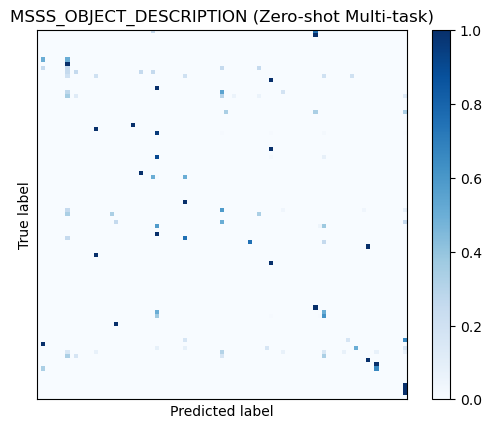

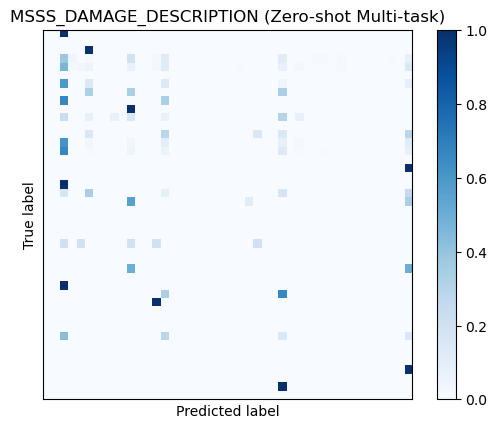

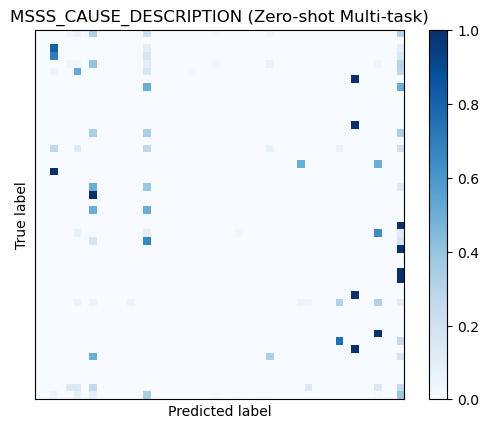

In [34]:
save_results(baseline_results)

# ▶️ Finetune LLM

In [21]:
FINETUNED_LLM_PATH = os.path.join(ROOT_DIR, "models/Qwen2.5-FT-EQ-1")

LORA_RANK_DIMENSION = 6 # the rank of the adapter, the lower the fewer parameters you'll need to train. (smaller = more compression)
LORA_ALPHA = 8 # this is the scaling factor for LoRA layers (higher = stronger adaptation)
LORA_DROPOUT = 0.05 # dropout probability for LoRA layers (helps prevent overfitting)
MAX_SEQ_LENGTH = 64
EPOCHS=2
LEARNING_RATE=2e-4

In [22]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=LORA_RANK_DIMENSION,
    lora_alpha=LORA_ALPHA,
    bias="none",
    lora_dropout=LORA_DROPOUT,
    task_type="CAUSAL_LM"
)

In [23]:
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    gradient_accumulation_steps=1,
    per_device_train_batch_size=16,
    auto_find_batch_size=True,
    
    max_seq_length=MAX_SEQ_LENGTH,
    packing=True,
    
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optim='adamw_torch_fused',
    warmup_ratio=0.03,
    lr_scheduler_type="constant", 
    
    logging_steps=10,
    logging_dir='./logs',
    output_dir=FINETUNED_LLM_PATH,
    report_to='none'
)

In [ ]:
history = ft.finetune( # Will save the model to the directory: FINETUNED_LLM_PATH
    model=model, tokenizer=tokenizer,
    train_dataset=dataset['train'],
    lora_config=lora_config, sft_config=sft_config
)

In [ ]:
history.to_csv(os.path.join(ROOT_DIR, "results/loss_history.csv"), index=False) # Save the training history

In [37]:
# Plot the training history and save the plot
import math
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 150
plt.plot(history.set_index("Step"))
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

loss_max = math.ceil(history['Training Loss'].max())
plt.ylim([0, loss_max])

plt.title("Fine-tuning Training History")

path = os.path.join(ROOT_DIR, "results/loss_history.png")
plt.savefig( path, dpi=200, bbox_inches='tight' )

NameError: name 'history' is not defined

# ▶️ Load Finetuned LLM

In [25]:
# Unload the baseline model if it exists, otherwise we will probably get an OOM exception
import gc, torch

if "bnb_config" in locals(): del bnb_config
if "tokenizer" in locals(): del tokenizer
if "model" in locals(): del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# FINETUNED_LLM_PATH = os.path.join(ROOT_DIR, "models/Qwen2.5-FT-EQ-1")
MODEL_DEVICE = "cuda:0"
QUANTIZED = True # Load model with 4-bit quantization

model, tokenizer = ft.load_finetuned_llm(FINETUNED_LLM_PATH, MODEL_DEVICE, QUANTIZED)

# ▶️ Evaluate Finetuned LLM

In [27]:
finetuned_configurations = [
    EvaluationConfig(
        name="Fine-tuned Multi-task",
        prompt=None,
        max_tokens=50
    )
]

In [ ]:
finetuned_results = evaluate_model(finetuned_configurations, model=model, tokenizer=tokenizer, label_names=label_names, eval_dataset=dataset['test'])

In [ ]:
save_results(finetuned_results)